<a href="https://colab.research.google.com/github/OmarCardoso/Projeto_fintech_fraudebancaria_uso_Rapid/blob/main/nvidia_fraud_detection_with_rapids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio 3 - Detecção de Fraude

Você precisa propor uma solução para detecção e análise de fraudes que possam reduzir os riscos da empresa e garantir margens saudáveis. Lembre-se, que o resultado do seu trabalho dará ainda mais visibilidade para você e sua área. Seja criterioso, utilize bons argumentos, fatos e justificativas para sua proposta, bem como, claro, faça uma boa execução do seu projeto.

# Programação em GPU

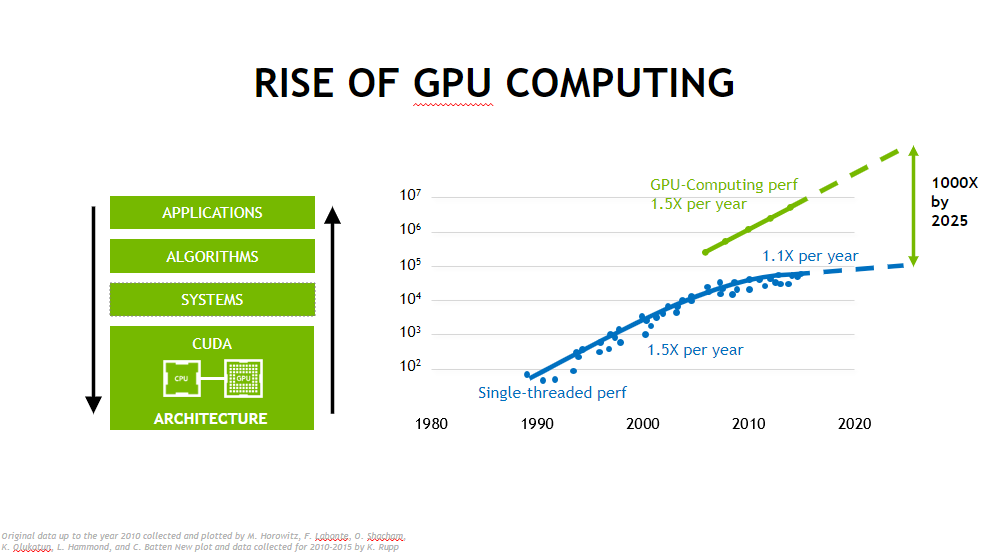

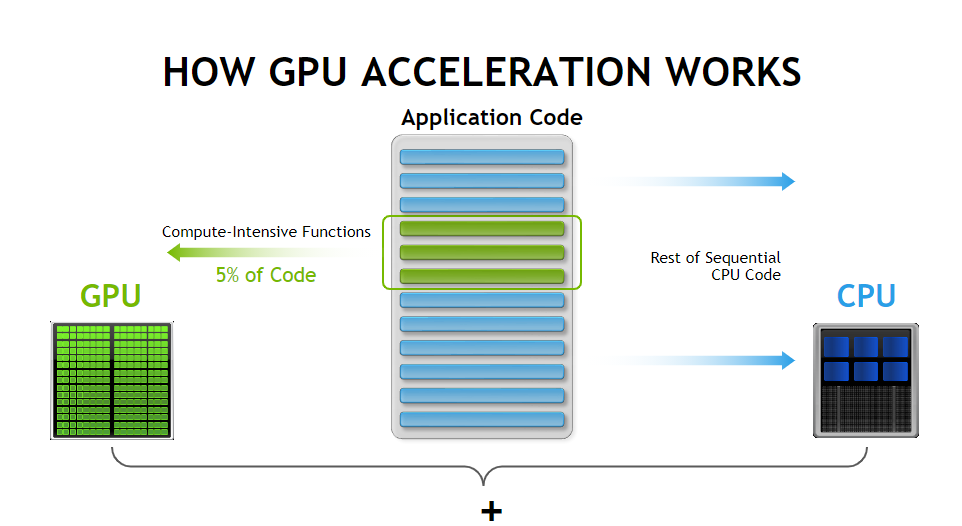

# Preparação do Ambiente

Importação dos pacotes que são necessários para a execução deste notebook. Estamos importando tanto pacotes que irão realizar o treinamento do modelo de Machine Learning na CPU (Sklearn) quanto o pacote que irá treinar os modelos em GPU (Rapids).

**Importante**: Caso você esteja executando através do Colaboratory do Google utilize essa referência para a preparação do ambiente: https://colab.research.google.com/github/ritchieng/deep-learning-wizard/blob/master/docs/machine_learning/gpu/rapids_cudf.ipynb. Este é um notebook com o passo a passo para a instalação das bibliotecas necessárias instalação das bibliotecas do [Rapids](https://rapids.ai/).

## Importação dos pacotes em Python

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para tratamento de dados em cpu
import pandas as pd
import numpy as np

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para treinamento e cálculo de métricas em CPU
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.model_selection import train_test_split as cpu_train_test_split
from sklearn.ensemble import RandomForestClassifier as cpu_RandomForestClassifier
from sklearn.metrics import accuracy_score as cpu_accuracy_score
from sklearn.metrics import confusion_matrix as cpu_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression as cpu_LogisticRegression

# Bibliotecas para treinamento e cálculo de métricas em GPU
from cuml.preprocessing import LabelEncoder as gpu_LabelEncoder
from cuml.preprocessing import Normalizer as gpu_Normalizer
from cuml import train_test_split as gpu_train_test_split
from cuml.ensemble import RandomForestClassifier as gpu_RandomForestClassifier
from cuml.metrics import accuracy_score as gpu_accuracy_score
from cuml.metrics import confusion_matrix as gpu_confusion_matrix
from cuml import LogisticRegression as gpu_LogisticRegression
import cupy
import cudf
import cuxfilter

# Algoritmo XGBoost
from xgboost import XGBClassifier

ModuleNotFoundError: ignored

In [ ]:
# Evita que o pandas apresente valores em notação científica
pd.set_option('display.float_format', lambda x: '%.5f' % x)

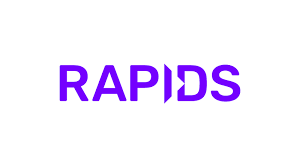

Instalação das bibliotecas do RAPIDS:
- [cuDF - GPU DataFrames](https://github.com/rapidsai/cudf)
- [cuML - GPU Machine Learning Algorithms](https://github.com/rapidsai/cuml)
- [cuGraph - GPU Graph Analytics](https://github.com/rapidsai/cugraph)
- [cuSpatial - GPU-Accelerated Spatial and Trajectory Data Management and Analytics Library](https://github.com/rapidsai/cuspatial)
- [cuSignal](https://github.com/rapidsai/cusignal)
- [XGBoost](https://rapids.ai/xgboost.html)
- [cuCIM](https://github.com/rapidsai/cucim)

### Medição de tempo de execução de uma célula

Utilizando o código no início da célula:
```python
%%time
```

Veja o exemplo abaixo:

In [ ]:
%%time
print("I am AI")

### Environment Sanity Check

Nesta seção estamos verificando qual e se existe pelo menos uma GPU disponível onde este notebook está sendo executado. Caso você esteja executando no Colaboratory, o Google pode disponibilizar alguma das GPUs: K80s, T4s, P4s ou P100s.

In [ ]:
!nvidia-smi

## Carregamento do Dataset

Nesta seção estamos carregando o dataset de fraudes em transações bancárias tanto em CPU quanto em GPU. Para a leitura do dataset direto para a memória da GPU estamos utilizando a biblioteca **cuDF**, muito semelhante ao **Pandas**.

#### GPU

In [ ]:
%%time
# Leitura do Dataset utilizando cudf
gpu_data = cudf.read_csv('./PS_20174392719_1491204439457_log.csv')
gpu_data.head(2)

In [ ]:
%%time
gpu_data.columns

#### CPU

In [ ]:
%%time
# Leitura do Dataset utilizando cudf
data = pd.read_csv('./PS_20174392719_1491204439457_log.csv')
data.head(2)

In [ ]:
%%time
data.columns

## Avaliando o dataset

#### GPU

In [ ]:
%%time
gpu_data.type.unique()

In [ ]:
%%time
gpu_data.info()

In [ ]:
%%time
# Verifica valores faltantes
gpu_data.isnull().sum()

#### CPU

In [ ]:
%%time
data.type.unique()

In [ ]:
%%time
data.info()

In [ ]:
%%time
# Verifica valores faltantes
data.isnull().sum()

## Análise Exploratória

In [ ]:
%%time
print(gpu_data.type.value_counts())
_ = sns.countplot(x="type", data=gpu_data.to_pandas())

Variável resposta

In [ ]:
%%time
print(gpu_data.isFraud.value_counts())
_ = sns.countplot(x="isFraud", data=gpu_data.to_pandas())

In [ ]:
8213/(6354407+8213)*100

In [ ]:
%%time
print(gpu_data.isFlaggedFraud.value_counts())
sns.countplot("isFlaggedFraud", data=gpu_data.to_pandas())

## Engenharia de Features

### Remoção de Amostras Duplicadas

#### GPU

In [ ]:
%%time
gpu_data.describe()

In [ ]:
%%time
gpu_data.shape

In [ ]:
%%time
gpu_data.drop_duplicates(keep=False, inplace=True)

In [ ]:
%%time
gpu_data.shape

#### CPU

In [ ]:
%%time
data.describe()

In [ ]:
%%time
data.shape

In [ ]:
%%time
# Drop Duplicates
data.drop_duplicates(keep=False, inplace=True)

In [ ]:
%%time
data.shape

### Categorização das Transferências

#### GPU

In [ ]:
%%time
def transfer_category(x):
    if x >= 75000:
        return('HIGH')
    elif x < 75000 and x >= 14000:
        return('MODERATE')
    elif x < 14000:
        return('LOW')
    else:
        return("EXTREMLY LOW")
gpu_data['transfer_amount_category'] = gpu_data.to_pandas().amount.apply(transfer_category)    
gpu_data.head(2)

#### CPU

In [ ]:
%%time
def transfer_category(x):
    if x >= 75000:
        return('HIGH')
    elif x < 75000 and x >= 14000:
        return('MODERATE')
    elif x < 14000:
        return('LOW')
    else:
        return("EXTREMLY LOW")
data['transfer_amount_category'] = data.amount.apply(transfer_category)    
data.head(2)

### Features Textuais

#### GPU

In [ ]:
%%time
gpu_label_encoder = gpu_LabelEncoder()
gpu_data['type_encode'] = gpu_label_encoder.fit_transform(gpu_data['type']) 
gpu_data['nameOrig_encode'] = gpu_label_encoder.fit_transform(gpu_data['nameOrig']) 
gpu_data['nameDest_encode'] = gpu_label_encoder.fit_transform(gpu_data['nameDest']) 
gpu_data['transfer_amount_category_encode'] = gpu_label_encoder.fit_transform(gpu_data['transfer_amount_category'])

In [ ]:
%%time
gpu_data.head(2)

In [ ]:
%%time
gpu_normalizer = gpu_Normalizer()
amount_scale = gpu_normalizer.fit_transform(gpu_data.amount.values.reshape(1,-1))
gpu_data['amount_norm'] = amount_scale.reshape(-1,1)
amount_oldbalanceOrg = gpu_normalizer.fit_transform(gpu_data.oldbalanceOrg.values.reshape(1,-1))
gpu_data['oldbalanceOrg_norm'] = amount_oldbalanceOrg.reshape(-1,1)
amount_newbalanceOrig = gpu_normalizer.fit_transform(gpu_data.newbalanceOrig.values.reshape(1,-1))
gpu_data['newbalanceOrig_norm'] = amount_newbalanceOrig.reshape(-1,1)
amount_oldbalanceDest= gpu_normalizer.fit_transform(gpu_data.oldbalanceDest.values.reshape(1,-1))
gpu_data['oldbalanceDest_norm'] = amount_oldbalanceDest.reshape(-1,1)
amount_newbalanceDest = gpu_normalizer.fit_transform(gpu_data.newbalanceDest.values.reshape(1,-1))
gpu_data['newbalanceDest_norm'] = amount_newbalanceDest.reshape(-1,1)

In [ ]:
%%time
gpu_data.head(2)

#### CPU

In [ ]:
%%time
label_encoder = LabelEncoder() 
data['type_encode'] = label_encoder.fit_transform(data['type']) 
data['nameOrig_encode'] = label_encoder.fit_transform(data['nameOrig']) 
data['nameDest_encode'] = label_encoder.fit_transform(data['nameDest']) 
data['transfer_amount_category_encode'] = label_encoder.fit_transform(data['transfer_amount_category']) 

In [ ]:
%%time
data.head(2)

In [ ]:
%%time
normalizer = Normalizer()
amount_scale = normalizer.fit_transform(data.amount.values.reshape(1,-1))
data['amount_norm'] = amount_scale.reshape(-1,1)
amount_oldbalanceOrg = normalizer.fit_transform(data.oldbalanceOrg.values.reshape(1,-1))
data['oldbalanceOrg_norm'] = amount_oldbalanceOrg.reshape(-1,1)
amount_newbalanceOrig = normalizer.fit_transform(data.newbalanceOrig.values.reshape(1,-1))
data['newbalanceOrig_norm'] = amount_newbalanceOrig.reshape(-1,1)
amount_oldbalanceDest= normalizer.fit_transform(data.oldbalanceDest.values.reshape(1,-1))
data['oldbalanceDest_norm'] = amount_oldbalanceDest.reshape(-1,1)
amount_newbalanceDest = normalizer.fit_transform(data.newbalanceDest.values.reshape(1,-1))
data['newbalanceDest_norm'] = amount_newbalanceDest.reshape(-1,1)

In [ ]:
%%time
data.head(2)

## Modelagem

Na etapa de modelagem vamos construir alguns modelos para executar a tarefa de classificação das transações que são fraude e transações que não são fraude.

### Split - Treino/Teste

#### GPU

In [ ]:
%%time
X = gpu_data[['type_encode','nameOrig_encode','nameDest_encode',
          'transfer_amount_category_encode','amount_norm',
          'oldbalanceOrg_norm','newbalanceOrig_norm',
          'oldbalanceDest_norm','newbalanceDest_norm']]
y = gpu_data["isFraud"]
X_cudf_train, X_cudf_test, y_train, y_test = gpu_train_test_split(X, y,
                                                    test_size = 0.33, 
                                                    stratify=y,
                                                    random_state = 42)

X_cudf_train = X_cudf_train.astype(np.float32)
X_cudf_test = X_cudf_test.astype(np.float32)

y_cudf_train = cudf.Series(y_train.values)
y_cudf_test = cudf.Series(y_test.values)

#### CPU

In [ ]:
%%time
X = data[['type_encode','nameOrig_encode','nameDest_encode',
          'transfer_amount_category_encode','amount_norm',
          'oldbalanceOrg_norm','newbalanceOrig_norm',
          'oldbalanceDest_norm','newbalanceDest_norm']]
y = data["isFraud"]
X_train, X_test, y_train, y_test = cpu_train_test_split(X, y,
                                                    test_size = 0.33, 
                                                    stratify=y,
                                                    random_state = 42)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

### Treinamento do modelo - Logistic Regression

#### GPU

In [ ]:
%%time
# Criando o modelo Regressão Logistica em GPU
gpu_clf = gpu_LogisticRegression()   
  
# Treinamento do modelo Regressão Logistica em GPU
gpu_clf.fit(X_cudf_train, y_cudf_train) 

In [ ]:
%%time
# Predições
y_pred_gpu = gpu_clf.predict(X_cudf_test) 

In [ ]:
%%time
# Calculando as métricas do modelo (Acurácia, Matriz de confusão)
print("Acurácia: ", gpu_accuracy_score(y_cudf_test, y_pred_gpu)) 
print("Matriz de confusão: ", gpu_confusion_matrix(y_cudf_test, y_pred_gpu.astype(np.int64)))

#### CPU

In [ ]:
%%time
# Criando o modelo Regressão Logistica em CPU
cpu_clf = cpu_LogisticRegression()   
  
# Treinamento do modelo Regressão Logistica em CPU
cpu_clf.fit(X_train, y_train) 

In [ ]:
%%time
# Predições
y_pred_cpu = cpu_clf.predict(X_test) 

In [ ]:
%%time
# Calculando as métricas do modelo (Acurácia, Matriz de confusão)
print("Acurácia: ", cpu_accuracy_score(y_test, y_pred_cpu))
print("Matriz de confusão: ", cpu_confusion_matrix(y_test, y_pred_cpu))

### Treinamento do modelo - RandomForest

#### GPU

In [ ]:
%%time
# Criando o modelo Random Forest em GPU
gpu_clf = gpu_RandomForestClassifier(n_estimators = 5, random_state = 42)   
  
# Treinamento do modelo Random Forest em GPU
gpu_clf.fit(X_cudf_train, y_cudf_train) 

In [ ]:
%%time
# Predições
y_pred_gpu = gpu_clf.predict(X_cudf_test) 

#### CPU

In [ ]:
%%time
# Criando o modelo Random Forest em CPU
cpu_clf = cpu_RandomForestClassifier(n_estimators = 5, random_state = 42)   
  
# Treinamento do modelo Random Forest em CPU
cpu_clf.fit(X_train, y_train) 

In [ ]:
%%time
# Predições
y_pred_cpu = cpu_clf.predict(X_test) 

### Metrificação do Modelo - Random Forest

#### GPU

In [ ]:
%%time
# Calculando as métricas do modelo (Acurácia, Matriz de confusão)
print("Acurácia: ", gpu_accuracy_score(y_cudf_test, y_pred_gpu)) 
print("Matriz de confusão: ", gpu_confusion_matrix(y_cudf_test, y_pred_gpu.astype(np.int64)))

In [ ]:
%%time
cm = cpu_confusion_matrix(y_cudf_test.to_pandas(), y_pred_gpu.to_pandas().astype(np.int64))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['não fraude', 'fraude'])
ax = disp.plot(values_format='d') 

In [ ]:
%%time
# Função que comentamos em sala sobre as propabilidades da classificação
y_pred_proba_gpu = gpu_clf.predict_proba(X_cudf_test)

In [ ]:
%%time
print(y_pred_proba_gpu[:5])

#### CPU

In [ ]:
%%time
# Calculando as métricas do modelo (Acurácia, Matriz de confusão)
print("Acurácia: ", cpu_accuracy_score(y_test, y_pred_cpu))
print("Matriz de confusão: ", cpu_confusion_matrix(y_test, y_pred_cpu))

In [ ]:
%%time
cm = cpu_confusion_matrix(y_test, y_pred_cpu)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['não fraude', 'fraude'])
_ = disp.plot(values_format='d') 

In [ ]:
%%time
# Função que comentamos em sala sobre as propabilidades da classificação
y_pred_proba = cpu_clf.predict_proba(X_test)

In [ ]:
%%time
print(y_pred_proba[:5])

### Treinamento do modelo - XGBoost

#### GPU

In [ ]:
%%time

# Parametrização do XGBoost
params = {'learning_rate': 0.1,
          'colsample_bytree' : 0.3,
          'max_depth': 5,
          'objective': 'binary:logistic',
          'alpha' : 10,          
          'tree_method':'gpu_hist',
          'predictor': 'gpu_predictor',
          'n_estimators': 100}

# Treinamento do modelo XGBoost
gpu_trained_model = XGBClassifier(**params)
gpu_trained_model.fit(X_train, y_train, eval_set=[(X_cudf_train, y_cudf_train.to_cupy().get()), 
                                                  (X_cudf_test, y_cudf_test.to_cupy().get())],
                      eval_metric='auc', verbose=False)

In [ ]:
%%time
# Predições
y_pred_gpu = gpu_trained_model.predict(X_cudf_test) 

#### CPU

In [ ]:
%%time

# Parametrização do XGBoost
params = {'learning_rate': 0.1,
          'colsample_bytree' : 0.3,
          'max_depth': 5,
          'objective': 'binary:logistic',
          'alpha' : 10,
          'n_estimators': 100}

# Treinamento do modelo XGBoost
cpu_trained_model = XGBClassifier(**params)
cpu_trained_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric='auc', verbose=False)

In [ ]:
%%time
# Predições
y_pred_cpu = cpu_trained_model.predict(X_test) 

### Metrificação do Modelo - XGBoost

#### GPU

In [ ]:
%%time
# Calculando as métricas do modelo (Acurácia, Matriz de confusão)
print("Acurácia: ", gpu_accuracy_score(y_cudf_test, y_pred_gpu)) 
print("Matriz de confusão: ", gpu_confusion_matrix(y_cudf_test, y_pred_gpu))

In [ ]:
%%time
fig, ax = plt.subplots()

evals_result = gpu_trained_model.evals_result()
x_axis = range(0, len(evals_result['validation_0']['auc']))

ax.plot(x_axis, evals_result['validation_0']['auc'], label='Train')
ax.plot(x_axis, evals_result['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

In [ ]:
%%time
cm = cpu_confusion_matrix(y_cudf_test.to_cupy().get(), y_pred_gpu.astype(np.int64))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['não fraude', 'fraude'])
ax = disp.plot(values_format='d') 

#### CPU

In [ ]:
%%time
# Calculando as métricas do modelo (Acurácia, Matriz de confusão)
print("Acurácia: ", cpu_accuracy_score(y_test, y_pred_cpu))
print("Matriz de confusão: ", cpu_confusion_matrix(y_test, y_pred_cpu))

In [ ]:
%%time
fig, ax = plt.subplots()

evals_result = cpu_trained_model.evals_result()
x_axis = range(0, len(evals_result['validation_0']['auc']))

ax.plot(x_axis, evals_result['validation_0']['auc'], label='Train')
ax.plot(x_axis, evals_result['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

In [ ]:
%%time
cm = cpu_confusion_matrix(y_test, y_pred_cpu.astype(np.int64))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['não fraude', 'fraude'])
_ = disp.plot(values_format='d') 

## Conclusões

##### Como está a nossa detecção de fraudes nesta solução proposta?

Vamos recapitular as métricas que foram obtidas para o XGBoost que foi treinado para este desafio. Lembrando que estas métricas foram obtidas para os dados de teste:

**Modelo XGBoost**

Matriz de confusão

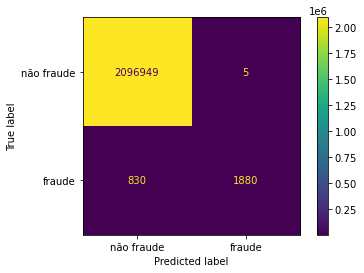

Neste cenário, 69% das fraudes foram detectadas corretamente com uma taxa verdadeiros negativos bem pequena (5 transações).

### Inferência

##### Por que o tempo de inferência é importante?

O tempo de inferência está diretamente ligado aos requisitos para colocar um modelo de Machine Learning em produção. Portanto, analisar as métricas de desempenho do modelo é fundamental, mas não é o único aspecto a ser levado em consideração ao definir que o modelo obtido atende todos os requisitos. Um dos requisitos do modelo pode ser o tempo de inferência. 

Vamos exemplificar um cenário onde o modelo que foi desenvolvido neste desafio seria colocado em produção.

## Referências

[Documentação - cuML](https://docs.rapids.ai/api/cuml/stable/api.html)

[RAPIDS Open GPU Data Science](https://rapids.ai/)

[NVIDIA Developer Blog](https://developer.nvidia.com/blog/)

[XGBoost - GPU Support](https://xgboost.readthedocs.io/en/latest/gpu/index.html)